In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier

In [2]:
LC = ["AT", "BE", "NL", "DE", "UK","EL", "EE","DK", "CZ", "CY", "BG", "FI", "FR", "HR", "HU","IE", "IT", "LT", "LU", "LV", "MT", "PL", "PT", "RO","SE", "SI", "SK"]

In [3]:
result = pd.DataFrame()
spec = pd.read_csv(r'D:\FARM_data\LUCAS2015_topsoildata_20200323\LUCAS_Topsoil_2015_20200323.csv')

for c in LC:
    df = pd.read_csv(f'D:\FARM_data\Soil_Spectra_s1\spectra_ {c} .csv')
    columns = df.columns[5:]
    columns = columns.insert(0, 'PointID')
    left = df[columns]
    right = spec[['Point_ID', 'OC']]
    right = right.rename(columns={'Point_ID': 'PointID'})
    r = pd.merge(left, right, on="PointID")
    result = pd.concat([result, r], axis=0)

In [4]:
Q1 = result['OC'].quantile(0.25)
Q3 = result['OC'].quantile(0.75)
IQR = Q3 - Q1
print(Q1, Q3, IQR)

13.5 41.3 27.799999999999997


In [5]:
result

,PointID,500,501,502,503,504,505,506,507,508,...,2391,2392,2393,2394,2395,2396,2397,2398,2399,OC
0,46442722,0.115892,0.116360,0.116835,0.117318,0.117808,0.118304,0.118808,0.119319,0.119834,...,0.214634,0.214631,0.214630,0.214630,0.214632,0.214634,0.214638,0.214640,0.214638,36.3
1,46442722,0.116520,0.116991,0.117471,0.117958,0.118454,0.118956,0.119466,0.119984,0.120504,...,0.216099,0.216088,0.216088,0.216092,0.216096,0.216099,0.216101,0.216102,0.216099,36.3
2,46522722,0.114212,0.114537,0.114869,0.115206,0.115545,0.115890,0.116242,0.116600,0.116961,...,0.260086,0.260105,0.260126,0.260151,0.260174,0.260190,0.260200,0.260203,0.260196,42.6
3,46522722,0.114390,0.114716,0.115049,0.115388,0.115731,0.116080,0.116436,0.116794,0.117154,...,0.261074,0.261102,0.261128,0.261152,0.261172,0.261186,0.261194,0.261197,0.261188,42.6
4,46882726,0.086649,0.086892,0.087144,0.087402,0.087666,0.087938,0.088219,0.088505,0.088796,...,0.223416,0.223443,0.223471,0.223496,0.223512,0.223521,0.223525,0.223521,0.223512,37.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,48482874,0.100911,0.101197,0.101492,0.101793,0.102101,0.102416,0.102735,0.103059,0.103389,...,0.384652,0.384486,0.384309,0.384119,0.383918,0.383713,0.383509,0.383313,0.383118,17.1
452,50722882,0.127186,0.127708,0.128243,0.128789,0.129349,0.129922,0.130507,0.131104,0.131710,...,0.377717,0.377680,0.377639,0.377590,0.377534,0.377472,0.377411,0.377344,0.377257,50.3
453,50722882,0.126892,0.127410,0.127940,0.128485,0.129045,0.129618,0.130202,0.130796,0.131400,...,0.376733,0.376704,0.376664,0.376610,0.376546,0.376475,0.376403,0.376334,0.376262,50.3
454,51822906,0.149872,0.150388,0.150915,0.151453,0.152004,0.152565,0.153136,0.153716,0.154306,...,0.301662,0.301448,0.301215,0.300966,0.300711,0.300455,0.300202,0.299945,0.299679,24.1


In [6]:
# comment voor 1e versie model
result = result[result['OC'] < Q3 + IQR * 1.5]
result = result[result['OC'] > Q1 - IQR * 1.5]

In [7]:
result

,PointID,500,501,502,503,504,505,506,507,508,...,2391,2392,2393,2394,2395,2396,2397,2398,2399,OC
0,46442722,0.115892,0.116360,0.116835,0.117318,0.117808,0.118304,0.118808,0.119319,0.119834,...,0.214634,0.214631,0.214630,0.214630,0.214632,0.214634,0.214638,0.214640,0.214638,36.3
1,46442722,0.116520,0.116991,0.117471,0.117958,0.118454,0.118956,0.119466,0.119984,0.120504,...,0.216099,0.216088,0.216088,0.216092,0.216096,0.216099,0.216101,0.216102,0.216099,36.3
2,46522722,0.114212,0.114537,0.114869,0.115206,0.115545,0.115890,0.116242,0.116600,0.116961,...,0.260086,0.260105,0.260126,0.260151,0.260174,0.260190,0.260200,0.260203,0.260196,42.6
3,46522722,0.114390,0.114716,0.115049,0.115388,0.115731,0.116080,0.116436,0.116794,0.117154,...,0.261074,0.261102,0.261128,0.261152,0.261172,0.261186,0.261194,0.261197,0.261188,42.6
4,46882726,0.086649,0.086892,0.087144,0.087402,0.087666,0.087938,0.088219,0.088505,0.088796,...,0.223416,0.223443,0.223471,0.223496,0.223512,0.223521,0.223525,0.223521,0.223512,37.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,48482874,0.100911,0.101197,0.101492,0.101793,0.102101,0.102416,0.102735,0.103059,0.103389,...,0.384652,0.384486,0.384309,0.384119,0.383918,0.383713,0.383509,0.383313,0.383118,17.1
452,50722882,0.127186,0.127708,0.128243,0.128789,0.129349,0.129922,0.130507,0.131104,0.131710,...,0.377717,0.377680,0.377639,0.377590,0.377534,0.377472,0.377411,0.377344,0.377257,50.3
453,50722882,0.126892,0.127410,0.127940,0.128485,0.129045,0.129618,0.130202,0.130796,0.131400,...,0.376733,0.376704,0.376664,0.376610,0.376546,0.376475,0.376403,0.376334,0.376262,50.3
454,51822906,0.149872,0.150388,0.150915,0.151453,0.152004,0.152565,0.153136,0.153716,0.154306,...,0.301662,0.301448,0.301215,0.300966,0.300711,0.300455,0.300202,0.299945,0.299679,24.1


In [8]:
result.columns[1:-1]

Index(['500', '501', '502', '503', '504', '505', '506', '507', '508', '509',
       ...
       '2390', '2391', '2392', '2393', '2394', '2395', '2396', '2397', '2398',
       '2399'],
      dtype='object', length=1900)

In [9]:
U_result = result.reset_index()
U_result

,index,PointID,500,501,502,503,504,505,506,507,...,2391,2392,2393,2394,2395,2396,2397,2398,2399,OC
0,0,46442722,0.115892,0.116360,0.116835,0.117318,0.117808,0.118304,0.118808,0.119319,...,0.214634,0.214631,0.214630,0.214630,0.214632,0.214634,0.214638,0.214640,0.214638,36.3
1,1,46442722,0.116520,0.116991,0.117471,0.117958,0.118454,0.118956,0.119466,0.119984,...,0.216099,0.216088,0.216088,0.216092,0.216096,0.216099,0.216101,0.216102,0.216099,36.3
2,2,46522722,0.114212,0.114537,0.114869,0.115206,0.115545,0.115890,0.116242,0.116600,...,0.260086,0.260105,0.260126,0.260151,0.260174,0.260190,0.260200,0.260203,0.260196,42.6
3,3,46522722,0.114390,0.114716,0.115049,0.115388,0.115731,0.116080,0.116436,0.116794,...,0.261074,0.261102,0.261128,0.261152,0.261172,0.261186,0.261194,0.261197,0.261188,42.6
4,4,46882726,0.086649,0.086892,0.087144,0.087402,0.087666,0.087938,0.088219,0.088505,...,0.223416,0.223443,0.223471,0.223496,0.223512,0.223521,0.223525,0.223521,0.223512,37.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31632,451,48482874,0.100911,0.101197,0.101492,0.101793,0.102101,0.102416,0.102735,0.103059,...,0.384652,0.384486,0.384309,0.384119,0.383918,0.383713,0.383509,0.383313,0.383118,17.1
31633,452,50722882,0.127186,0.127708,0.128243,0.128789,0.129349,0.129922,0.130507,0.131104,...,0.377717,0.377680,0.377639,0.377590,0.377534,0.377472,0.377411,0.377344,0.377257,50.3
31634,453,50722882,0.126892,0.127410,0.127940,0.128485,0.129045,0.129618,0.130202,0.130796,...,0.376733,0.376704,0.376664,0.376610,0.376546,0.376475,0.376403,0.376334,0.376262,50.3
31635,454,51822906,0.149872,0.150388,0.150915,0.151453,0.152004,0.152565,0.153136,0.153716,...,0.301662,0.301448,0.301215,0.300966,0.300711,0.300455,0.300202,0.299945,0.299679,24.1


In [10]:
U_result.sort_values(by='OC',ascending=True)

,index,PointID,500,501,502,503,504,505,506,507,...,2391,2392,2393,2394,2395,2396,2397,2398,2399,OC
20260,1888,45482304,0.260048,0.261202,0.262379,0.263579,0.264799,0.266037,0.267291,0.268561,...,0.459820,0.459648,0.459466,0.459273,0.459071,0.458857,0.458627,0.458378,0.458111,0.1
20261,1889,45482304,0.261440,0.262602,0.263787,0.264995,0.266223,0.267470,0.268732,0.270010,...,0.462984,0.462818,0.462647,0.462468,0.462275,0.462064,0.461836,0.461596,0.461343,0.1
20014,1640,46821620,0.214016,0.214996,0.215996,0.217015,0.218049,0.219099,0.220166,0.221248,...,0.469290,0.469206,0.469132,0.469054,0.468961,0.468846,0.468711,0.468562,0.468408,0.2
6344,527,55681794,0.164227,0.164952,0.165694,0.166452,0.167226,0.168014,0.168815,0.169625,...,0.344557,0.344601,0.344643,0.344682,0.344711,0.344731,0.344744,0.344749,0.344748,0.2
6343,526,55681794,0.163831,0.164558,0.165301,0.166062,0.166839,0.167629,0.168429,0.169239,...,0.344708,0.344741,0.344772,0.344802,0.344828,0.344851,0.344867,0.344877,0.344880,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21660,210,51203750,0.088518,0.088726,0.088938,0.089154,0.089374,0.089600,0.089828,0.090058,...,0.365559,0.365338,0.365111,0.364871,0.364617,0.364354,0.364089,0.363824,0.363554,82.8
5735,1373,35163756,0.073576,0.073809,0.074048,0.074293,0.074543,0.074800,0.075064,0.075334,...,0.227500,0.227456,0.227403,0.227339,0.227268,0.227203,0.227148,0.227097,0.227039,82.9
17328,216,47702398,0.086247,0.086416,0.086588,0.086766,0.086950,0.087138,0.087332,0.087531,...,0.303730,0.303518,0.303303,0.303081,0.302856,0.302633,0.302417,0.302202,0.301979,82.9
17329,217,47702398,0.085751,0.085918,0.086090,0.086268,0.086452,0.086640,0.086833,0.087032,...,0.302974,0.302768,0.302560,0.302340,0.302106,0.301867,0.301632,0.301400,0.301168,82.9


In [11]:
U_result.loc[22426][2:-1].values
# 82 = 17328
# 560.2 = 11214
# 0.1 = 22426

array([0.17427416, 0.17496734, 0.17566935, ..., 0.43423218, 0.43418518,
       0.4341282 ])

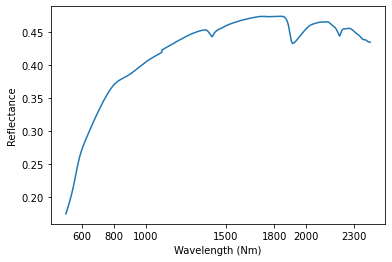

In [12]:
plt.xlabel('Wavelength (Nm)')
plt.ylabel('Reflectance')
plt.xticks([100, 300, 500, 1000, 1300, 1500, 1800, 2000, 2300, 2500])

plt.plot(result.columns[1:-1], U_result.loc[22426][2:-1].values)

In [13]:
U_result['OC'].describe()

count    31637.000000
mean        24.918257
std         16.667604
min          0.100000
25%         12.800000
50%         19.600000
75%         32.400000
max         82.900000
Name: OC, dtype: float64

In [14]:
X = U_result[U_result.columns[2:-1]].values
X
y = U_result[U_result.columns[-1]].values
y

array([36.3, 36.3, 42.6, ..., 50.3, 24.1, 24.1])

## Linear Regression

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,  random_state=3)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [16]:
y_pred = model.predict(X_test)

In [17]:
# baseline
# y_pred_base = [47.845879 for _ in range(len(y_test))]

In [18]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

9.991999881194571

In [19]:
model.score(X_test, y_test)

0.6342506939209982

In [20]:
# avg = [sum(lst)/len(lst) for lst in X_test]

In [21]:
# plt.plot(sorted(y_pred), avg)

## Decision tree regressor

In [22]:
DT = tree.DecisionTreeRegressor()

In [23]:
DT.fit(X_train, y_train)

DecisionTreeRegressor()

In [24]:
y_predDT = DT.predict(X_test)

In [25]:
np.sqrt(metrics.mean_squared_error(y_test, y_predDT))

13.226957338801615

In [26]:
DT.score(X_test, y_test)

0.3590877447719715

In [27]:
DT.get_n_leaves()

18773

In [28]:
DT.get_depth()

35

In [29]:
DT.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

## Random forest tree regression

In [30]:
# RF = RandomForestRegressor(max_depth=1, random_state=3)

In [31]:
# RF.fit(X_train, y_train)

In [32]:
# y_predRF = DT.predict(X_test)

In [33]:
# np.sqrt(metrics.mean_squared_error(y_test, y_predRF))

In [34]:
# RF.score(X_test, y_test)

## XGBoost

In [35]:
# XG = XGBClassifier()

In [36]:
# XG.fit(X_train,y_train)

In [37]:
# y_predXG = XG.predict(X_test)

In [38]:
# np.sqrt(metrics.mean_squared_error(y_test, y_predXG))

In [39]:
# XG.score(X_test, y_test)

In [40]:
# clf = LogisticRegression(random_state=3)

In [41]:
# clf.fit(X_train, y_train)

In [42]:
# y_predc = clf.predict(X_test)

In [43]:
# np.sqrt(metrics.mean_squared_error(y_test, y_predc))

In [44]:
# clf.score(X_test, y_test)

In [45]:
# degree=3
# polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
# polyreg.fit(X_train,y_train)

In [46]:
# y_pred = polyreg.predict(X_test)

In [47]:
# np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [48]:
# polyreg.score(X_test, y_test)